In [1]:
import sys
import math
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data

In [2]:
def draw(steps, accs, losses, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot([i for i in range(steps)], losses, '-', color='#4169E1', alpha=0.8, linewidth=1)
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} Loss Chart')
    ax2.plot([i for i in range(steps)], accs, '-', color='#4169E1', alpha=0.8, linewidth=1)
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} Accuracy Chart')
    plt.show()

In [3]:
class PalindromeDataset(data.Dataset):

    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        return sys.maxsize

    def __getitem__(self, idx):
        full_palindrome = self.generate_palindrome()
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))

In [4]:
class VanillaRNN(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.Whx = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Whh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wph = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.bh = nn.Parameter(torch.zeros(1, hidden_dim))
        self.bo = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        h = torch.zeros(batch_size, self.hidden_dim)
        for t in range(self.seq_length):
            h = torch.tanh(torch.mm(x[:, t].reshape(-1, 1), self.Whx) + torch.mm(h, self.Whh) + self.bh)
        output = torch.mm(h, self.Wph) + self.bo
        return output

In [5]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.Wgx = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Wgh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bg = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wix = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Wih = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bi = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wfx = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Wfh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bf = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wox = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Woh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bo = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wph = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.bp = nn.Parameter(torch.randn(1, output_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        h = torch.zeros(batch_size, self.hidden_dim)
        c = torch.zeros(batch_size, self.hidden_dim)
        for t in range(self.seq_length):
            xt = x[:, t].reshape(-1, 1)
            gt = torch.tanh(torch.mm(xt, self.Wgx) + torch.mm(h, self.Wgh) + self.bg)
            it = torch.sigmoid(torch.mm(xt, self.Wix) + torch.mm(h, self.Wih) + self.bi)
            ft = torch.sigmoid(torch.mm(xt, self.Wfx) + torch.mm(h, self.Wfh) + self.bf)
            ot = torch.sigmoid(torch.mm(xt, self.Wox) + torch.mm(h, self.Woh) + self.bo)
            c = gt * it + c * ft
            h = torch.tanh(c) * ot
        return torch.mm(h, self.Wph) + self.bp

In [6]:
steps = 50000
step_limit = 40000
batch_size = 128
input_dim = 1
hidden_dim = 128
output_dim = 10

In [7]:
def main(model_name, length):
    model = train(model_name, length)
    test(model, model_name, length)

In [8]:
def train(model_name, length):
    if model_name == 'VanillaRNN':
        model = VanillaRNN(length-1, input_dim, hidden_dim, output_dim)
    elif model_name == 'LSTM':
        model = LSTM(length-1, input_dim, hidden_dim, output_dim)
    else:
        raise Exception('Model name not supported!')
    losses, accs = [], []
    range_acc = []
    dataset = PalindromeDataset(length)
    data_loader = data.DataLoader(dataset, batch_size)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs, batch_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.mean(np.argmax(batch_outputs.detach().numpy(), axis=1) == batch_targets.detach().numpy())
        losses.append(loss.item())
        accs.append(acc)
        if step % 10000 == 0:
            print('Step: ', step, 'Loss: ', loss.item(), 'Accuracy: ', acc)
        if step == steps - 1:
            print('Step: ', step, 'Loss: ', loss.item(), 'Accuracy: ', acc)
            break
        if step >= step_limit:
            range_acc.append(acc)
    print(f'Average accuracy steps {step_limit} - {steps}: {np.mean(range_acc)}')
    draw(steps, accs, losses, model_name)
    return model

In [9]:
def test(model, model_name, length):
    model.eval()
    dataset = PalindromeDataset(length)
    data_loader = data.DataLoader(dataset, batch_size=128)
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        batch_outputs = model(batch_inputs)
        acc = np.mean(np.argmax(batch_outputs.detach().numpy(), axis=1) == batch_targets.detach().numpy())
        print(f'{model_name} Test Accuracy :', acc)
        break

Step:  0 Loss:  14.803945541381836 Accuracy:  0.125
Step:  10000 Loss:  1.4342613220214844 Accuracy:  0.6953125
Step:  20000 Loss:  0.00011148511111969128 Accuracy:  1.0
Step:  30000 Loss:  0.0012209730921313167 Accuracy:  1.0
Step:  40000 Loss:  1.593395063537173e-05 Accuracy:  1.0
Step:  49999 Loss:  4.486048510443652e-06 Accuracy:  1.0
Average accuracy steps 40000 - 50000: 0.9993874387438744


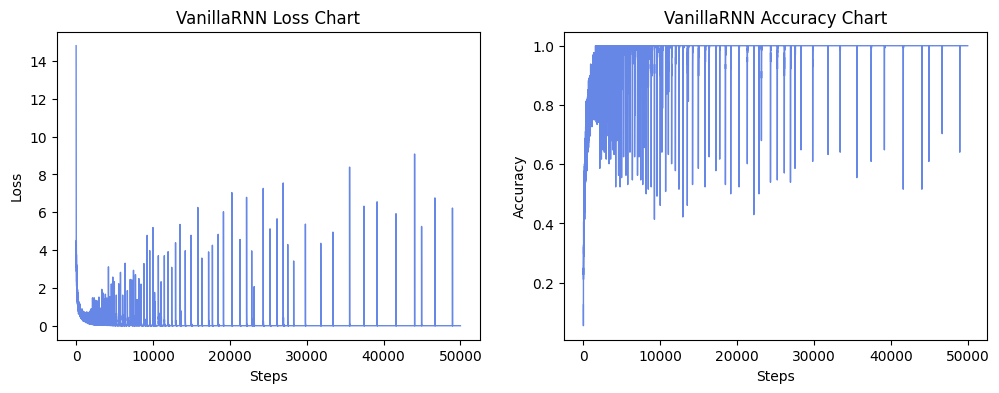

VanillaRNN Test Accuracy : 1.0


In [10]:
length = 5
main("VanillaRNN", length)

Step:  0 Loss:  10.236400604248047 Accuracy:  0.0859375
Step:  10000 Loss:  2.8124707114329794e-06 Accuracy:  1.0
Step:  20000 Loss:  2.0302527445892338e-06 Accuracy:  1.0
Step:  30000 Loss:  1.154838713546269e-07 Accuracy:  1.0
Step:  40000 Loss:  9.313224857976365e-09 Accuracy:  1.0
Step:  49999 Loss:  0.00043355891830287874 Accuracy:  1.0
Average accuracy steps 40000 - 50000: 0.9998288891389139


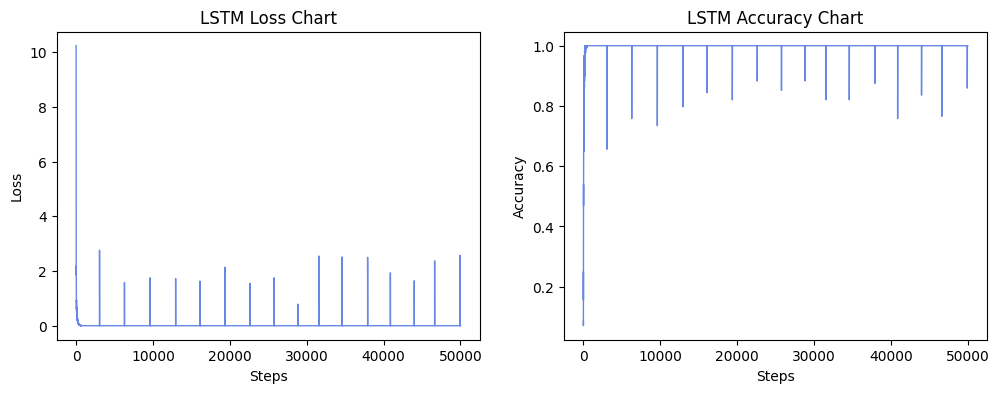

LSTM Test Accuracy : 1.0


In [11]:
length = 5
main("LSTM", length)

Step:  0 Loss:  18.49205780029297 Accuracy:  0.0703125
Step:  10000 Loss:  1.7639188766479492 Accuracy:  0.2421875
Step:  20000 Loss:  1.26837158203125 Accuracy:  0.4296875
Step:  30000 Loss:  1.0078445672988892 Accuracy:  0.53125
Step:  40000 Loss:  0.6133123636245728 Accuracy:  0.71875
Step:  49999 Loss:  0.748542070388794 Accuracy:  0.765625
Average accuracy steps 40000 - 50000: 0.8234128100310031


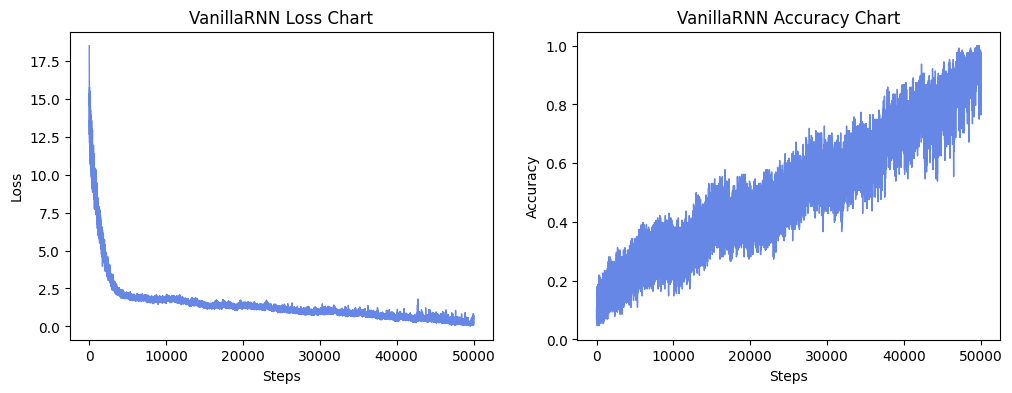

VanillaRNN Test Accuracy : 0.734375


In [12]:
length = 10
main("VanillaRNN", length)

Step:  0 Loss:  7.551258563995361 Accuracy:  0.1171875
Step:  10000 Loss:  0.00020664895419031382 Accuracy:  1.0
Step:  20000 Loss:  6.877035048091784e-06 Accuracy:  1.0
Step:  30000 Loss:  1.089157103706384e-05 Accuracy:  1.0
Step:  40000 Loss:  9.313225191043273e-10 Accuracy:  1.0
Step:  49999 Loss:  2.7939675018018306e-09 Accuracy:  1.0
Average accuracy steps 40000 - 50000: 0.9998015426542655


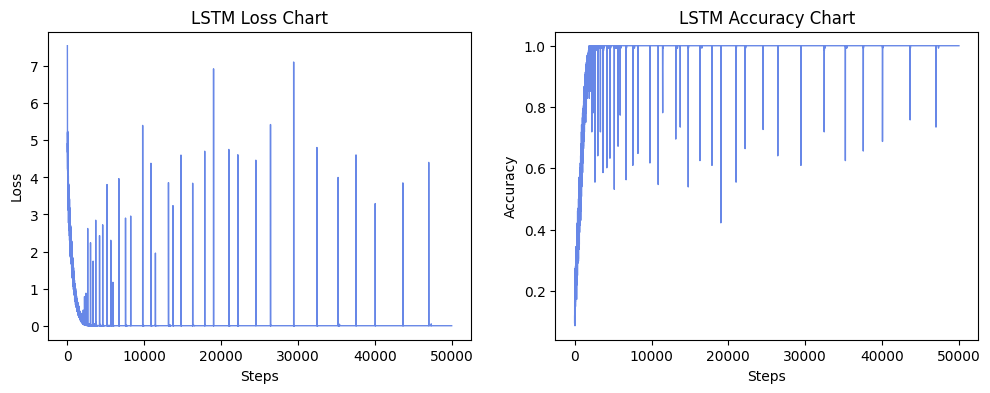

LSTM Test Accuracy : 1.0


In [13]:
length = 10
main("LSTM", length)

Step:  0 Loss:  16.31340980529785 Accuracy:  0.125
Step:  10000 Loss:  2.254274845123291 Accuracy:  0.1328125
Step:  20000 Loss:  2.2689523696899414 Accuracy:  0.15625
Step:  30000 Loss:  2.2398955821990967 Accuracy:  0.1640625
Step:  40000 Loss:  2.273590087890625 Accuracy:  0.15625
Step:  49999 Loss:  2.1379306316375732 Accuracy:  0.203125
Average accuracy steps 40000 - 50000: 0.14883519601960196


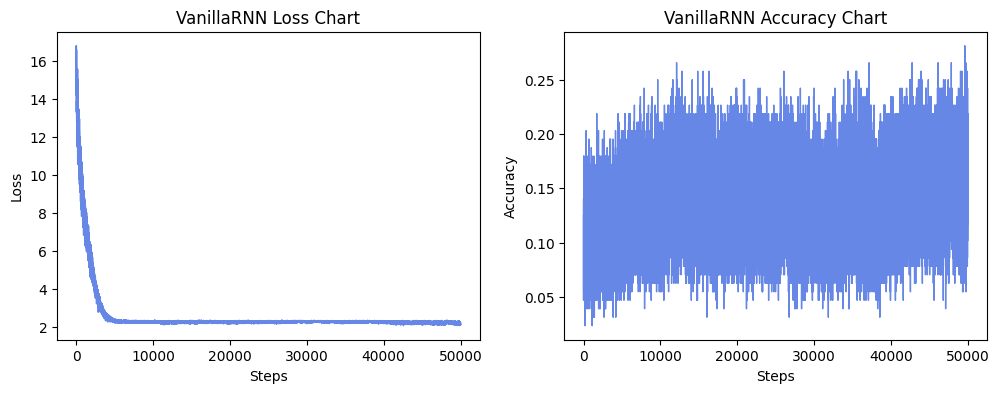

VanillaRNN Test Accuracy : 0.1796875


In [14]:
length = 15
main("VanillaRNN", length)

Step:  0 Loss:  8.297404289245605 Accuracy:  0.1171875
Step:  10000 Loss:  0.00024303670215886086 Accuracy:  1.0
Step:  20000 Loss:  5.878310912521556e-05 Accuracy:  1.0
Step:  30000 Loss:  8.704140054760501e-05 Accuracy:  1.0
Step:  40000 Loss:  1.3379458323470317e-05 Accuracy:  1.0
Step:  49999 Loss:  1.6707788290659664e-06 Accuracy:  1.0
Average accuracy steps 40000 - 50000: 0.9997601322632264


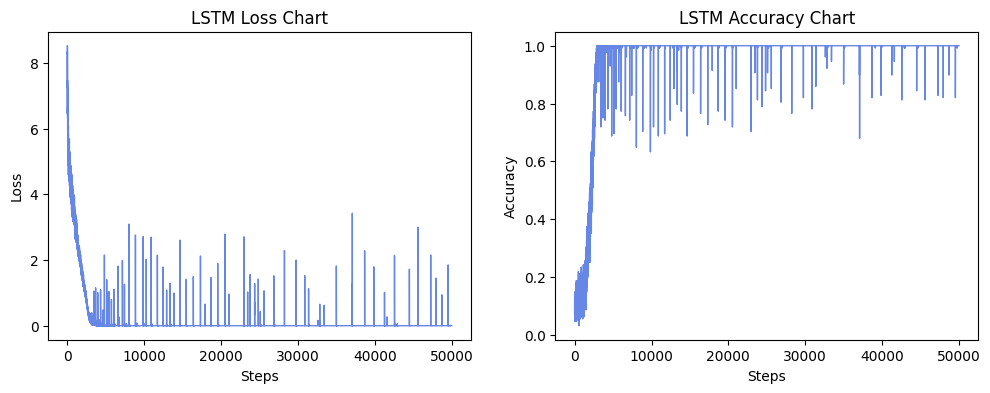

LSTM Test Accuracy : 1.0


In [15]:
length = 15
main("LSTM", length)

Step:  0 Loss:  14.573315620422363 Accuracy:  0.078125
Step:  10000 Loss:  2.3156349658966064 Accuracy:  0.109375
Step:  20000 Loss:  2.307060480117798 Accuracy:  0.109375
Step:  30000 Loss:  2.280919313430786 Accuracy:  0.140625
Step:  40000 Loss:  2.303520917892456 Accuracy:  0.0703125
Step:  49999 Loss:  2.3092403411865234 Accuracy:  0.125
Average accuracy steps 40000 - 50000: 0.10796235873587359


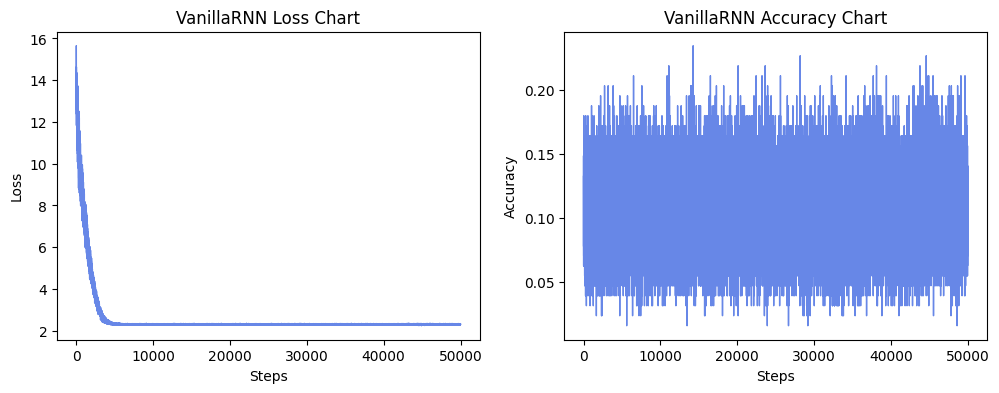

VanillaRNN Test Accuracy : 0.109375


In [16]:
length = 20
main("VanillaRNN", length)

Step:  0 Loss:  6.014617443084717 Accuracy:  0.1796875
Step:  10000 Loss:  0.002071279799565673 Accuracy:  1.0
Step:  20000 Loss:  0.00010554971231613308 Accuracy:  1.0
Step:  30000 Loss:  4.241192800691351e-05 Accuracy:  1.0
Step:  40000 Loss:  4.019495918328175e-06 Accuracy:  1.0
Step:  49999 Loss:  2.8684684139079764e-07 Accuracy:  1.0
Average accuracy steps 40000 - 50000: 0.9997741961696169


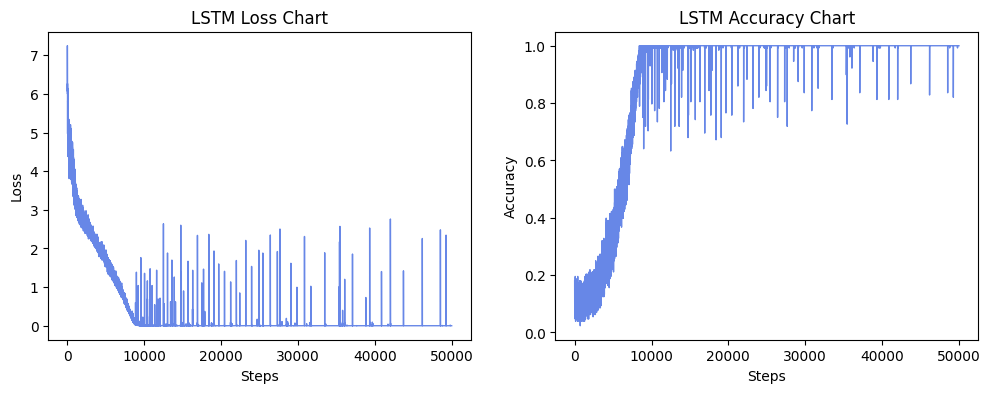

LSTM Test Accuracy : 1.0


In [17]:
length = 20
main("LSTM", length)